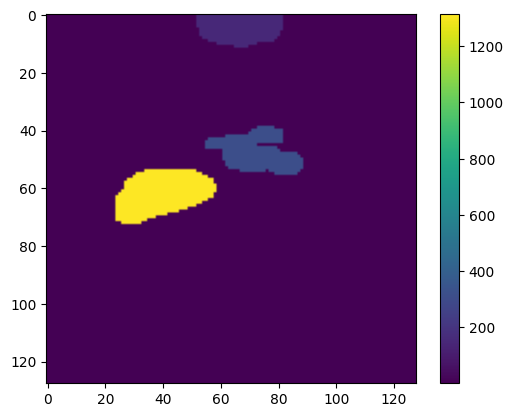

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import nibabel as ni
import SimpleITK as sitk

file_path1 = "Output_2025-09-30/SIMIND_Outputs/PBPK_100_act_av.bin"

arr = np.fromfile(file_path1, dtype=np.float32).reshape((128, 128, 128))
plt.imshow(arr[64,:,:])
plt.colorbar()
plt.show()






tensor(0.)


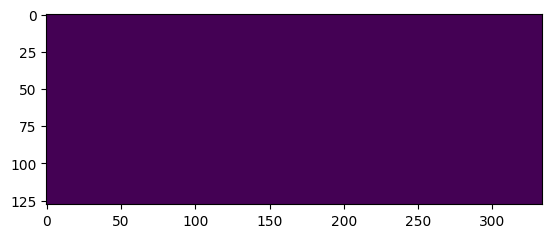

In [31]:
import numpy as np, matplotlib.pyplot as plt
import torch

from pytomography.io.SPECT import simind

photopeak_path = 'Output_2025-09-30/SIMIND_Outputs/simind_frame1_tot_w2.h00'
photopeak = simind.get_projections(photopeak_path)

print(torch.sum(photopeak))
plt.imshow(photopeak[5,:,:])
#vol = sitk.GetArrayFromImage(sitk.ReadImage('Output_2025-09-30/RECON_Outputs/RECON_frame1.nii'))
#plt.imshow(vol[vol.shape[0]//2, :, :], cmap='gray'); plt.axis('off')